In [1]:
import pandas as pd
import numpy as np
import ast
import cv2
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
contours=pd.read_csv("../input/RANZCR_CLiP_lung_contours/RANZCR_CLiP_lung_contours.csv")
dataset_dir="../input/ranzcr-clip-catheter-line-classification/"

display(contours)

,StudyInstanceUID,left_lung_contour,right_lung_contour
0,1.2.826.0.1.3680043.8.498.67437000721567007663...,"[[1260, 264], [1260, 271], [1259, 272], [1250,...","[[918, 360], [918, 367], [917, 368], [840, 368..."
1,1.2.826.0.1.3680043.8.498.79881958372061574254...,"[[1524, 168], [1524, 175], [1523, 176], [1504,...","[[1055, 168], [1055, 175], [1054, 176], [1016,..."
2,1.2.826.0.1.3680043.8.498.11906973334615329097...,"[[1563, 496], [1563, 503], [1562, 504], [1543,...","[[879, 504], [879, 511], [878, 512], [840, 512..."
3,1.2.826.0.1.3680043.8.498.55260237650588247757...,"[[1719, 550], [1719, 560], [1718, 561], [1683,...","[[1029, 515], [1029, 525], [1028, 526], [1006,..."
4,1.2.826.0.1.3680043.8.498.67911234832894662081...,"[[1348, 360], [1348, 367], [1347, 368], [1319,...","[[938, 304], [938, 311], [937, 312], [899, 312..."
...,...,...,...
30078,1.2.826.0.1.3680043.8.498.12035496198910189553...,"[[1683, 187], [1683, 198], [1682, 199], [1648,...","[[1146, 152], [1146, 163], [1145, 164], [1076,..."
30079,1.2.826.0.1.3680043.8.498.12086799165644989654...,"[[1260, 232], [1260, 239], [1259, 240], [1231,...","[[821, 304], [821, 311], [820, 312], [811, 312..."
30080,1.2.826.0.1.3680043.8.498.93420867605990042763...,"[[1612, 320], [1612, 327], [1611, 328], [1543,...","[[928, 280], [928, 287], [927, 288], [889, 288..."
30081,1.2.826.0.1.3680043.8.498.35571390858435755665...,"[[1348, 128], [1348, 135], [1347, 136], [1329,...","[[948, 152], [948, 159], [947, 160], [938, 160..."


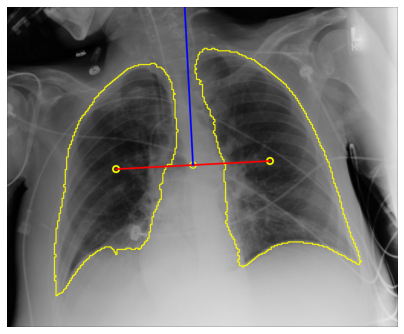

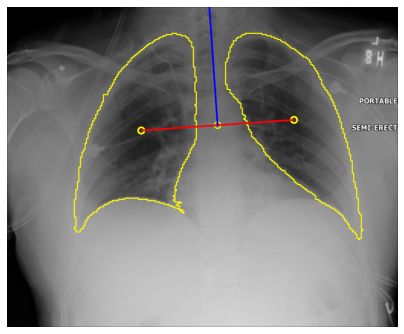

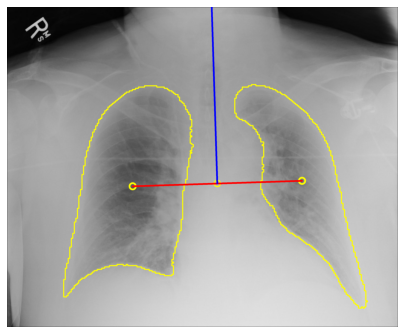

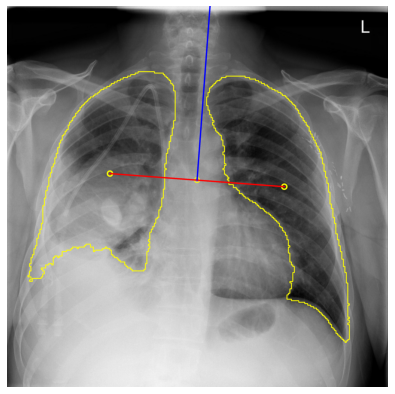

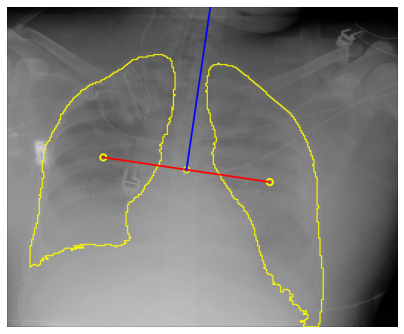

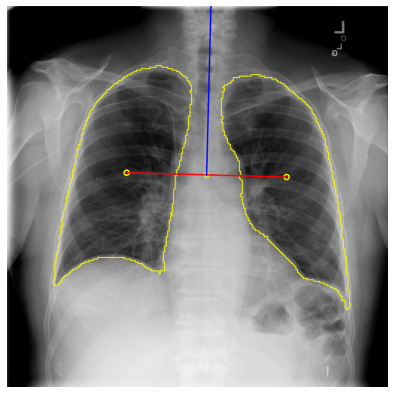

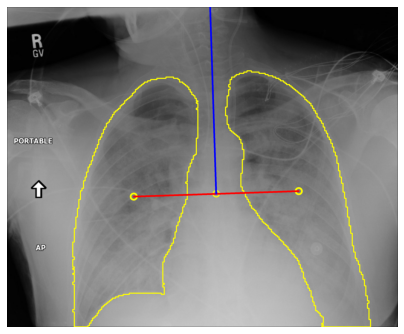

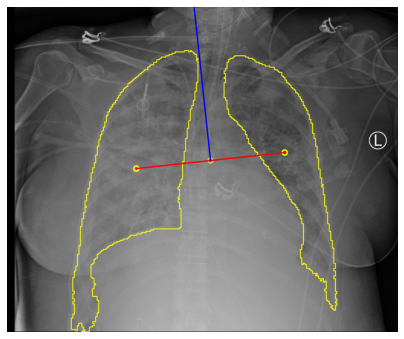

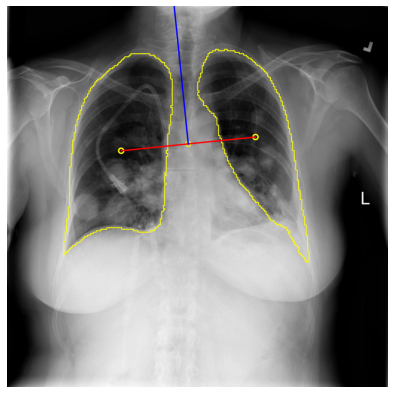

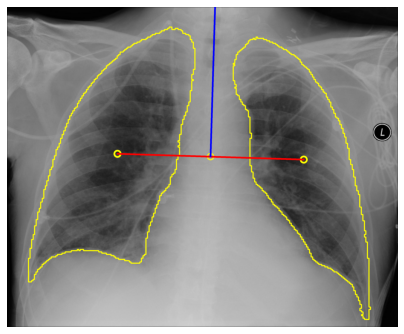

In [3]:
def get_rotation_matrix(rad):
    rot=np.array([
        [np.cos(rad),-np.sin(rad)],
        [np.sin(rad),np.cos(rad)]])
    return rot

def get_gravity_center(ctr_array):
    M=cv2.moments(ctr_array)
    g=(int(M["m10"]/M["m00"]),int(M["m01"]/M["m00"]))
    return g

def get_annotated_image(uid):
    row=contours[contours["StudyInstanceUID"]==uid]

    ctr_left=ast.literal_eval(row["left_lung_contour"].values[0])
    ctr_right=ast.literal_eval(row["right_lung_contour"].values[0])

    ctr_left_array=np.expand_dims(np.array(ctr_left),axis=0)
    ctr_right_array=np.expand_dims(np.array(ctr_right),axis=0)

    img=cv2.imread(f"{dataset_dir}train/{uid}.jpg")
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.drawContours(img,ctr_left_array,0,(255,255),5)
    img=cv2.drawContours(img,ctr_right_array,0,(255,255),5)

    g1=get_gravity_center(ctr_left_array)
    g2=get_gravity_center(ctr_right_array)
    g1_array=np.array(g1)
    g2_array=np.array(g2)
    c=(g1_array+g2_array)/2

    img=cv2.circle(img,g1,20,(255,255),10)
    img=cv2.circle(img,g2,20,(255,255,),10)
    img=cv2.circle(img,tuple(c.astype(int)),20,(255,255,),5)

    vec=g2_array-c
    vec_rotated=np.dot(get_rotation_matrix(np.pi/2),vec)
    img=cv2.line(img,g1,g2,(255),10)
    img=cv2.line(img,tuple(c.astype(int)),tuple(c.astype(int)+3*vec_rotated.astype(int)),(0,0,255),10)

    return img

def image_show(img,title=None):
    fig,ax=plt.subplots(1,1,figsize=(7,7))
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")


for i in range(10):
    uid=contours["StudyInstanceUID"][i]
    img=get_annotated_image(uid)
    image_show(img)

In [53]:
def get_gravity_center(ctr_array):
    M=cv2.moments(ctr_array)
    g=np.array([M["m10"]/M["m00"],M["m01"]/M["m00"]])
    return g

def get_theta(ctr_left,ctr_right):
    base_vec=np.array([1,0])
    ctr_left_array=np.expand_dims(np.array(ctr_left),axis=0)
    ctr_right_array=np.expand_dims(np.array(ctr_right),axis=0)
    g1=get_gravity_center(ctr_left_array)
    g2=get_gravity_center(ctr_right_array)

    vec=g2-g1
    cross_product=np.cross(base_vec,vec)
    sin=cross_product/(np.linalg.norm(vec)*1)
    theta=np.arcsin(sin)
    return theta


results_list=[]
for uid in tqdm(contours["StudyInstanceUID"]):
    row=contours[contours["StudyInstanceUID"]==uid]
    ctr_left=ast.literal_eval(row["left_lung_contour"].values[0])
    ctr_right=ast.literal_eval(row["right_lung_contour"].values[0])
    
    theta=get_theta(ctr_left,ctr_right)
    results_list.append([uid,theta])

rotation=pd.DataFrame(results_list,columns=["StudyInstanceUID","theta"])
rotation.to_csv("../input/rotation_theta.csv",index=False)
display(rotation)

  0%|          | 0/30083 [00:00<?, ?it/s]

,StudyInstanceUID,theta
0,1.2.826.0.1.3680043.8.498.67437000721567007663...,0.053009
1,1.2.826.0.1.3680043.8.498.79881958372061574254...,0.069360
2,1.2.826.0.1.3680043.8.498.11906973334615329097...,0.032564
3,1.2.826.0.1.3680043.8.498.55260237650588247757...,-0.074762
4,1.2.826.0.1.3680043.8.498.67911234832894662081...,-0.147165
...,...,...
30078,1.2.826.0.1.3680043.8.498.12035496198910189553...,0.084704
30079,1.2.826.0.1.3680043.8.498.12086799165644989654...,0.329137
30080,1.2.826.0.1.3680043.8.498.93420867605990042763...,0.031656
30081,1.2.826.0.1.3680043.8.498.35571390858435755665...,-0.054405


In [61]:
rotation.loc[rotation["theta"].idxmin(),"StudyInstanceUID"]

'1.2.826.0.1.3680043.8.498.47961794463420407241615995005629280022'